In [1]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from sklearn import metrics
import lightgbm as lgb
import pandas as pd
import numpy as np
import tqdm
import os
import gc
import sys
sys.path.append('../code/pipeline/')
sys.path.append('../code/utils/')
sys.path.append('../code/')
import data_pipeline as dp
import eval_utils as eu
import data_utils as du
import perf_utils as pu
import io_utils as iu
import config

In [2]:
log_folder = os.path.join(config.LOG_DIR, 'lgbm/pipeline/0507/')
log_file = 'v2.online_auc.csv'
log_path = os.path.join(log_folder, log_file)
df_log = pd.read_csv(log_path)

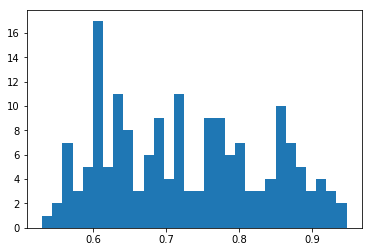

In [3]:
auc_by_aid = df_log["auc"]
plt.hist(auc_by_aid, bins=30)
plt.show()

In [4]:
df_ad = du.load_raw_data("ad")
ad = df_ad.copy()
ad = pd.merge(ad, df_log, on="aid")

In [5]:
ad.sort_values("auc", ascending=False)

,aid,advertiserId,campaignId,creativeId,creativeSize,adCategoryId,productId,productType,auc
36,2054,915,31020,794412,22,51,0,4,0.947292
123,613,915,31020,546986,22,51,0,4,0.936784
39,1672,327,110094,942499,35,67,113,9,0.932849
91,519,370,358059,577602,22,67,113,9,0.930475
64,1957,388,404,1513931,22,27,113,9,0.922272
49,1930,58643,407774,683342,35,67,113,9,0.919408
103,725,370,170485,1485462,22,67,113,9,0.917422
9,450,45705,352827,565415,42,67,0,4,0.914098
90,1375,370,67127,249293,35,27,113,9,0.906421
4,671,45705,352827,660519,42,67,0,4,0.901852


In [6]:
ad[ad["auc"] < 0.73].sort_values("auc", ascending=False)

,aid,advertiserId,campaignId,creativeId,creativeSize,adCategoryId,productId,productType,auc
155,286,25485,104406,131847,42,51,15454,11,0.725665
23,231,11487,159012,991964,20,1,0,4,0.723940
82,966,915,31020,666210,22,51,0,4,0.721366
135,411,9106,163120,220179,79,21,0,4,0.720587
161,2044,49772,487541,869346,35,9,0,9,0.719939
167,1635,2775,3372,145496,22,59,0,4,0.718962
156,2118,11195,19215,1012717,53,140,0,4,0.718654
99,1351,7229,17378,1203413,35,24,6131,11,0.718647
170,389,9106,662422,1354071,79,21,0,4,0.717921
119,1910,23805,61383,326633,42,149,14314,11,0.716351


In [7]:
ad["isBad"] = (ad["auc"] < 0.73)

In [8]:
df_train = du.load_raw_data("train")
df_test = du.load_raw_data("test")
train = pd.merge(df_train, ad[["aid", "isBad"]], on="aid", how="left")
test = pd.merge(df_test, ad[["aid", "isBad"]], on="aid", how="left")

In [13]:
mask_train = train["isBad"]
mask_test = test["isBad"]
good_indices_tv = train[~mask_train].index.values
good_indices_test = test[~mask_test].index.values
bad_indices_tv = train[mask_train].index.values
bad_indices_test = test[mask_test].index.values
print("Bad Train Records: {}/{}".format(mask_train.sum(), df_train.shape[0]))
print("Bad Test Records: {}/{}".format(mask_test.sum(), df_test.shape[0]))

Bad Train Records: 5376816/8798814
Bad Test Records: 1386500/2265989


In [14]:
dm = dp.DataManager(config.INPUT_DIR)
bin_loader = dm.build_data("raw", "binary")

In [15]:
with pu.profiler("loading training data"):
    cols_tv, X_tv = bin_loader.load("train")
    X_tv = sparse.csr_matrix(X_tv)
    gc.collect()

[13:39:23] Finish loading training data. △M: +3.26GB. △T: 5.7 seconds.


In [16]:
with pu.profiler("slicing training data by aid"):
    X_tv_bad = X_tv[bad_indices_tv, :]
    X_tv_good = X_tv[good_indices_tv, :]
    
    assert X_tv_bad.shape[0] + X_tv_good.shape[0] == X_tv.shape[0]
    assert X_tv_bad.shape[1] == X_tv_good.shape[1]
    
    del X_tv
    gc.collect()

[13:39:40] Finish slicing training data by aid. △M: +41.04MB. △T: 17.1 seconds.


In [17]:
y = df_train['label'].values.copy()
y = (y + 1) / 2  # -1, 1 -> 0, 1

In [21]:
y_bad = y[mask_train]
y_good = y[~mask_train]

In [20]:
n_splits = 3  # use 3 instead of 5 to save time
skf = StratifiedKFold(n_splits=n_splits)

split_indices_good = [(train_index, valid_index) for train_index, valid_index in skf.split(train[~mask_train], y[~mask_train])]
split_indices_bad = [(train_index, valid_index) for train_index, valid_index in skf.split(train[mask_train], y[mask_train])]

In [22]:
with pu.profiler("splitting train/valid set for bad advertise"):
    train_index, valid_index = split_indices_bad[0]
    X_train_bad, X_valid_bad = X_tv_bad[train_index, :], X_tv_bad[valid_index, :]
    y_train_bad, y_valid_bad = y_bad[train_index], y_bad[valid_index]
    assert X_train_bad.shape[0] + X_valid_bad.shape[0] == X_tv_bad.shape[0]
    
    del X_tv_bad
    gc.collect()
    
print("Training Set (Bad Advertise) Size: {}".format(X_train_bad.shape))
print("Validation Set (Bad Advertise) Size: {}".format(X_valid_bad.shape))

[13:46:04] Finish splitting train/valid set for bad advertise. △M: -35.33MB. △T: 10.5 seconds.
Training Set (Bad Advertise) Size: (3584544, 419701)
Validation Set (Bad Advertise) Size: (1792272, 419701)


In [24]:
with pu.profiler("preparing LightGBM data"):
    lgb_train_bad = lgb.Dataset(X_train_bad.astype(np.float32), y_train_bad, feature_name=cols_tv)
    lgb_valid_bad = lgb.Dataset(X_valid_bad.astype(np.float32), y_valid_bad, feature_name=cols_tv)
    gc.collect()

[13:46:57] Finish preparing LightGBM data. △M: +3.14GB. △T: 2.6 seconds.


In [25]:
log_folder = os.path.join(config.LOG_DIR, 'lgbm/pipeline/0507/')
log_file = 'v3_badAd.log'
log_path = os.path.join(log_folder, log_file)
os.makedirs(log_folder, exist_ok=True)

In [27]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 15,
    'num_leaves': 120,
    'learning_rate': 0.15,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': 0
}
num_rounds = 500

with iu.DuplicatedLogger(log_path):
    lgbm_bad = lgb.train(params,
                         lgb_train_bad,
                         num_boost_round=num_rounds,
                         valid_sets=[lgb_train_bad, lgb_valid_bad], 
                         valid_names=['train', 'valid1'],
                         early_stopping_rounds=50)

[1]	train's auc: 0.592705	valid1's auc: 0.59128
Training until validation scores don't improve for 50 rounds.
[2]	train's auc: 0.610867	valid1's auc: 0.608702
[3]	train's auc: 0.615385	valid1's auc: 0.61349
[4]	train's auc: 0.617841	valid1's auc: 0.616072
[5]	train's auc: 0.621377	valid1's auc: 0.619639
[6]	train's auc: 0.622418	valid1's auc: 0.620945
[7]	train's auc: 0.625125	valid1's auc: 0.623167
[8]	train's auc: 0.625661	valid1's auc: 0.623523
[9]	train's auc: 0.628131	valid1's auc: 0.62584
[10]	train's auc: 0.628148	valid1's auc: 0.625675
[11]	train's auc: 0.628886	valid1's auc: 0.626201
[12]	train's auc: 0.630577	valid1's auc: 0.627747
[13]	train's auc: 0.631199	valid1's auc: 0.628244
[14]	train's auc: 0.632174	valid1's auc: 0.629157
[15]	train's auc: 0.633981	valid1's auc: 0.630827
[16]	train's auc: 0.636021	valid1's auc: 0.632786
[17]	train's auc: 0.637838	valid1's auc: 0.634173
[18]	train's auc: 0.639067	valid1's auc: 0.635148
[19]	train's auc: 0.640554	valid1's auc: 0.636452


[164]	train's auc: 0.728504	valid1's auc: 0.662414
[165]	train's auc: 0.728949	valid1's auc: 0.662398
[166]	train's auc: 0.729187	valid1's auc: 0.66242
[167]	train's auc: 0.729518	valid1's auc: 0.662425
[168]	train's auc: 0.7299	valid1's auc: 0.662427
[169]	train's auc: 0.7304	valid1's auc: 0.662406
[170]	train's auc: 0.730664	valid1's auc: 0.662393
[171]	train's auc: 0.730912	valid1's auc: 0.662372
[172]	train's auc: 0.731168	valid1's auc: 0.662374
[173]	train's auc: 0.731492	valid1's auc: 0.662371
[174]	train's auc: 0.731798	valid1's auc: 0.662322
[175]	train's auc: 0.73191	valid1's auc: 0.66233
[176]	train's auc: 0.732019	valid1's auc: 0.662324
[177]	train's auc: 0.732248	valid1's auc: 0.662253
[178]	train's auc: 0.732605	valid1's auc: 0.662246
[179]	train's auc: 0.732905	valid1's auc: 0.662211
[180]	train's auc: 0.733207	valid1's auc: 0.662218
[181]	train's auc: 0.733616	valid1's auc: 0.662206
[182]	train's auc: 0.733871	valid1's auc: 0.662134
[183]	train's auc: 0.734229	valid1's a

In [29]:
log_file = 'v3_badAd.feature_importance.csv'
log_path = os.path.join(log_folder, log_file)

df_feature_importance_bad = pd.DataFrame({"feature": cols_tv, "importance": lgbm_bad.feature_importance()})
df_feature_importance_bad = df_feature_importance_bad.sort_values("importance", ascending=False)
df_feature_importance_bad.to_csv(log_path, index=False)
df_feature_importance_bad.head(30)

,feature,importance
419614,creativeSize_59,285
419697,productType_4,142
915,interest1_49,122
419630,adCategoryId_21,116
419207,ct_1,106
1003,interest1_6,88
3,age_2,88
1092,interest2_[nan],87
6,gender_2,81
419261,aid_561,81


In [34]:
df_tv_bad = df_train[mask_train]
df_valid_bad = df_tv_bad.iloc[valid_index]
proba_valid_bad = lgbm_bad.predict(X_valid_bad.astype(np.float32))
df_score_bad = eu.online_auc(df_valid_bad['aid'], y_valid_bad, proba_valid_bad, ret_verbose=True)
df_score_bad

,aid,auc
0,6,0.635474
1,18,0.582199
2,74,0.667539
3,86,0.622145
4,113,0.547880
5,117,0.660504
6,136,0.633813
7,177,0.639808
8,206,0.577514
9,212,0.639672


In [38]:
online_auc_bad = df_score_bad['auc'].mean()
simple_auc_bad = metrics.roc_auc_score(y_valid_bad, proba_valid_bad)
simple_auc_bad_old = ad[ad["isBad"]]['auc'].mean()
print("Online AUC: {:.6f}".format(online_auc_bad))
print("Simple AUC: {:.6f}".format(simple_auc_bad))
print("Online AUC (Old): {:.6f}".format(simple_auc_bad_old))

Online AUC: 0.644782
Simple AUC: 0.662668
Online AUC (Old): 0.639730


In [39]:
with pu.profiler("splitting train/valid set for good advertise"):
    train_index, valid_index = split_indices_good[0]
    X_train_good, X_valid_good = X_tv_good[train_index, :], X_tv_good[valid_index, :]
    y_train_good, y_valid_good = y_good[train_index], y_good[valid_index]
    assert X_train_good.shape[0] + X_valid_good.shape[0] == X_tv_good.shape[0]

    del X_tv_good
    gc.collect()

print("Training Set (good Advertise) Size: {}".format(X_train_good.shape))
print("Validation Set (good Advertise) Size: {}".format(X_valid_good.shape))

with pu.profiler("preparing LightGBM data"):
    lgb_train_good = lgb.Dataset(X_train_good.astype(np.float32), y_train_good, feature_name=cols_tv)
    lgb_valid_good = lgb.Dataset(X_valid_good.astype(np.float32), y_valid_good, feature_name=cols_tv)
    gc.collect()

[14:09:07] Finish splitting train/valid set for good advertise. △M: +0B. △T: 6.7 seconds.
Training Set (good Advertise) Size: (2281331, 419701)
Validation Set (good Advertise) Size: (1140667, 419701)
[14:09:09] Finish preparing LightGBM data. △M: +1.99GB. △T: 1.8 seconds.


In [40]:
log_folder = os.path.join(config.LOG_DIR, 'lgbm/pipeline/0507/')
log_file = 'v3_goodAd.log'
log_path = os.path.join(log_folder, log_file)
os.makedirs(log_folder, exist_ok=True)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 15,
    'num_leaves': 120,
    'learning_rate': 0.15,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'verbose': 0
}
num_rounds = 500

with iu.DuplicatedLogger(log_path):
    lgbm_good = lgb.train(params,
                          lgb_train_good,
                          num_boost_round=num_rounds,
                          valid_sets=[lgb_train_good, lgb_valid_good], 
                          valid_names=['train', 'valid1'],
                          early_stopping_rounds=50)

[1]	train's auc: 0.747163	valid1's auc: 0.746946
Training until validation scores don't improve for 50 rounds.
[2]	train's auc: 0.771477	valid1's auc: 0.77067
[3]	train's auc: 0.776898	valid1's auc: 0.776269
[4]	train's auc: 0.777183	valid1's auc: 0.776386
[5]	train's auc: 0.780176	valid1's auc: 0.779198
[6]	train's auc: 0.783265	valid1's auc: 0.782198
[7]	train's auc: 0.784815	valid1's auc: 0.783655
[8]	train's auc: 0.785862	valid1's auc: 0.784649
[9]	train's auc: 0.786953	valid1's auc: 0.785452
[10]	train's auc: 0.787504	valid1's auc: 0.785911
[11]	train's auc: 0.789003	valid1's auc: 0.787248
[12]	train's auc: 0.790434	valid1's auc: 0.788695
[13]	train's auc: 0.790866	valid1's auc: 0.788962
[14]	train's auc: 0.792389	valid1's auc: 0.790394
[15]	train's auc: 0.79335	valid1's auc: 0.791182
[16]	train's auc: 0.794714	valid1's auc: 0.792499
[17]	train's auc: 0.795689	valid1's auc: 0.793259
[18]	train's auc: 0.797172	valid1's auc: 0.794663
[19]	train's auc: 0.798006	valid1's auc: 0.795251

[164]	train's auc: 0.869439	valid1's auc: 0.82326
[165]	train's auc: 0.869667	valid1's auc: 0.823269
[166]	train's auc: 0.869968	valid1's auc: 0.823289
[167]	train's auc: 0.870252	valid1's auc: 0.823344
[168]	train's auc: 0.870454	valid1's auc: 0.823342
[169]	train's auc: 0.870635	valid1's auc: 0.823353
[170]	train's auc: 0.870806	valid1's auc: 0.823338
[171]	train's auc: 0.870997	valid1's auc: 0.823351
[172]	train's auc: 0.87127	valid1's auc: 0.823435
[173]	train's auc: 0.871543	valid1's auc: 0.823452
[174]	train's auc: 0.871722	valid1's auc: 0.823455
[175]	train's auc: 0.872046	valid1's auc: 0.823485
[176]	train's auc: 0.872249	valid1's auc: 0.823486
[177]	train's auc: 0.872544	valid1's auc: 0.823534
[178]	train's auc: 0.872721	valid1's auc: 0.82352
[179]	train's auc: 0.873025	valid1's auc: 0.823557
[180]	train's auc: 0.873233	valid1's auc: 0.823566
[181]	train's auc: 0.873379	valid1's auc: 0.823576
[182]	train's auc: 0.873538	valid1's auc: 0.823579
[183]	train's auc: 0.873699	valid1

[326]	train's auc: 0.896036	valid1's auc: 0.823978
[327]	train's auc: 0.896128	valid1's auc: 0.823962
[328]	train's auc: 0.896317	valid1's auc: 0.823967
[329]	train's auc: 0.8965	valid1's auc: 0.823976
[330]	train's auc: 0.896625	valid1's auc: 0.823982
[331]	train's auc: 0.896745	valid1's auc: 0.824001
[332]	train's auc: 0.896887	valid1's auc: 0.824004
[333]	train's auc: 0.896946	valid1's auc: 0.824005
[334]	train's auc: 0.897066	valid1's auc: 0.823998
[335]	train's auc: 0.897192	valid1's auc: 0.824007
[336]	train's auc: 0.897426	valid1's auc: 0.824016
[337]	train's auc: 0.897495	valid1's auc: 0.824012
[338]	train's auc: 0.897568	valid1's auc: 0.824019
[339]	train's auc: 0.897725	valid1's auc: 0.824025
[340]	train's auc: 0.897867	valid1's auc: 0.824007
[341]	train's auc: 0.897966	valid1's auc: 0.823995
[342]	train's auc: 0.898035	valid1's auc: 0.823992
[343]	train's auc: 0.898131	valid1's auc: 0.823995
[344]	train's auc: 0.898206	valid1's auc: 0.823977
[345]	train's auc: 0.898326	valid

In [41]:
log_file = 'v3_goodAd.feature_importance.csv'
log_path = os.path.join(log_folder, log_file)

df_feature_importance_good = pd.DataFrame({"feature": cols_tv, "importance": lgbm_good.feature_importance()})
df_feature_importance_good = df_feature_importance_good.sort_values("importance", ascending=False)
df_feature_importance_good.to_csv(log_path, index=False)
df_feature_importance_good.head(30)

,feature,importance
3,age_2,348
419611,creativeSize_35,285
1057,interest2_54,269
1033,interest2_70,265
419610,creativeSize_22,258
419699,productType_9,239
11,marriageStatus_10,217
31,consumptionAbility_1,206
1002,interest1_76,205
915,interest1_49,204


In [42]:
df_tv_good = df_train[~mask_train]
df_valid_good = df_tv_good.iloc[valid_index]
proba_valid_good = lgbm_good.predict(X_valid_good.astype(np.float32))
df_score_good = eu.online_auc(df_valid_good['aid'], y_valid_good, proba_valid_good, ret_verbose=True)
df_score_good

,aid,auc
0,7,0.798009
1,12,0.854866
2,70,0.863204
3,98,0.765623
4,121,0.838004
5,145,0.778351
6,164,0.901866
7,173,0.772669
8,174,0.726771
9,191,0.755074


In [45]:
online_auc_good = df_score_good['auc'].mean()
simple_auc_good = metrics.roc_auc_score(y_valid_good, proba_valid_good)
simple_auc_good_old = ad[~ad["isBad"]]['auc'].mean()
print("Online AUC: {:.6f}".format(online_auc_good))
print("Simple AUC: {:.6f}".format(simple_auc_good))
print("Online AUC (Old): {:.6f}".format(simple_auc_good_old))

Online AUC: 0.828117
Simple AUC: 0.824160
Online AUC (Old): 0.828249


In [47]:
online_auc_all = (df_score_good['auc'].sum() + df_score_bad['auc'].sum()) / (df_score_good.shape[0] + df_score_bad.shape[0])
online_auc_all_old = ad['auc'].mean()
print("Online AUC All: {:.6f}".format(online_auc_all))
print("Online AUC All (Old): {:.6f}".format(online_auc_all_old))

Online AUC All: 0.729561
Online AUC All (Old): 0.726907


In [48]:
good_indices_test
bad_indices_test

with pu.profiler("loading testing data"):
    cols_test, X_test = bin_loader.load("test1")
    X_test = sparse.csr_matrix(X_test)
    gc.collect()
    
with pu.profiler("slicing testing data by aid"):
    X_test_bad = X_test[bad_indices_test, :]
    X_test_good = X_test[good_indices_test, :]
    
    assert X_test_bad.shape[0] + X_test_good.shape[0] == X_test.shape[0]
    assert X_test_bad.shape[1] == X_test_good.shape[1]
    
    del X_test
    gc.collect()

[14:36:18] Finish loading testing data. △M: +872.02MB. △T: 1.6 seconds.
[14:36:23] Finish slicing testing data by aid. △M: -65.29MB. △T: 4.3 seconds.


In [50]:
with pu.profiler("making prediction on testing set"):
    proba_test_bad = lgbm_bad.predict(X_test_bad.astype(np.float32))
    proba_test_good = lgbm_good.predict(X_test_good.astype(np.float32))
    
    assert len(proba_test_bad.shape) == 1
    assert len(proba_test_good.shape) == 1
    assert proba_test_bad.shape[0] + proba_test_good.shape[0] == df_test.shape[0]

[14:38:51] Finish making prediction on testing set. △M: +28.0KB. △T: 26.1 seconds.


In [51]:
subm_folder = '../subm/lgbm/0507_v3'
subm_file = 'submission.csv'
subm_path = os.path.join(subm_folder, subm_file)
os.makedirs(subm_folder, exist_ok=True)

subm = df_test.copy()
subm["score"] = -1
subm.loc[bad_indices_test, "score"] = proba_test_bad
subm.loc[good_indices_test, "score"] = proba_test_good
subm.to_csv(subm_path, index=False)